# Оценка точности модели, переобучение, регуляризация

Цель: закрепить знания о математическом смысле метрик TPR, FPR. Изучить построение ROC-кривой, графика Precision-Recall.

Описание задания:
Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.

## Работа с предоставленными данными

__Произведем чтение предоставленного файла с данными по атлетам:__

In [72]:
# для чего изначально подгрузим в проект библиотеку
import pandas as pd

In [73]:
# прочтем данный файл средствами ЯП
authlets_data = pd.read_csv('athletes.csv')
# удалим строки в которых содержаться пустые ячейки
authlets_data_cleaned = authlets_data.dropna()
# выведем полученный очищенный датасет
authlets_data_cleaned

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11533,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0,0,0
11534,214461847,Zuzana Hejnova,CZE,female,12/19/86,1.73,63.0,athletics,0,0,0
11535,88361042,di Xiao,CHN,male,5/14/91,1.85,100.0,wrestling,0,0,0
11536,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0,0,0


__Проведем нормировку данных в полученном датасете:__

Для чего воспользуемся классом `LabelEncoder`, который применяется для преобразования категориальных признаков в числовой формат.

In [210]:
# импортируем в проект класс библиотеки
from sklearn.preprocessing import LabelEncoder
# создаем копию датафрейма, в котором как раз и будем проводить нормировку
authlets_data_cleaned_copy = authlets_data_cleaned.copy()
label_encoder = LabelEncoder()
# проводим нормировку
authlets_data_cleaned_copy['name'] = label_encoder.fit_transform(authlets_data_cleaned['name'])
authlets_data_cleaned_copy['nationality'] = label_encoder.fit_transform(authlets_data_cleaned['nationality'])
authlets_data_cleaned_copy['sex'] = label_encoder.fit_transform(authlets_data_cleaned['sex'])
authlets_data_cleaned_copy['dob'] = label_encoder.fit_transform(authlets_data_cleaned['dob'])
authlets_data_cleaned_copy['height'] = label_encoder.fit_transform(authlets_data_cleaned['height'])
authlets_data_cleaned_copy['weight'] = label_encoder.fit_transform(authlets_data_cleaned['weight'])
authlets_data_cleaned_copy['sport'] = label_encoder.fit_transform(authlets_data_cleaned['sport'])
authlets_data_cleaned_copy['gold'] = label_encoder.fit_transform(authlets_data_cleaned['gold'])
authlets_data_cleaned_copy['silver'] = label_encoder.fit_transform(authlets_data_cleaned['silver'])
authlets_data_cleaned_copy['bronze'] = label_encoder.fit_transform(authlets_data_cleaned['bronze'])

# смотрим результат
authlets_data_cleaned_copy


,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,0,59,1,611,36,31,2,0,0,0
1,532037425,1,101,0,5238,32,23,8,0,0,0
2,435962603,2,33,1,3436,62,46,2,0,0,1
3,521041435,3,117,1,189,47,47,21,0,0,0
4,33922579,4,138,1,1197,45,38,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11533,265605954,10835,48,0,4559,28,25,2,0,0,0
11534,214461847,10836,50,0,1498,37,30,2,0,0,0
11535,88361042,10837,38,1,3223,49,67,26,0,0,0
11536,900065925,10838,195,1,3082,24,23,25,0,0,0


## Подготовка выборки

__Разделим выборку на обучающее (80% данных) и тестовое (20% данных) подмножества:__

_Произведем операции по разделению выборки на обучающую и тестовую, помимо этого исключим некоторые столбцы из итогового датафрейма, которые могут представлять лишний шум и влиять на точность модели. Для целевой переменной предлагаем использовать столбец `sex`, который содержит после нормировки бинарное представление 0/1. Поэтому в качестве выполнения задания в рамках данной работы предлагаем использовать этот столбец, тогда получаемая модель будет предсказывать по полученным наблюдениям принадлежность к определенному классу `sex`_

In [253]:
# добавим класс train_test_split, который позволит выполнить деление
from sklearn.model_selection import train_test_split

# в рамках решения задачи по разделению выборки на подмножества предлагаю воспользоваться функцией train_test_split
# изначально произведем извлечение из датафрейма всех признаков кроме 'id', 'name', 'nationality', 'sex'

columns_to_exclude = ['id', 'name', 'nationality', 'sex']

# извлечение признаков X (все столбцы, кроме тех что в массиве columns_to_exclude)

X = authlets_data_cleaned_copy.drop(columns_to_exclude, axis=1)  # axis=1 указывает на столбцы
# извлечение целевой переменной y (столбец 'sex')
y = authlets_data_cleaned_copy['sex']

# далее воспользуемся заявленной функцией
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# где
# X_train, X_test - обучающее и тестовое подмножества признаков
# y_train, y_test - соответствующие им целевые переменные
# test_size = 0.2 указывает, что 20% данных будет отведено под тестовое множество
# random_state = 42 устанавливает начальное значение для генератора случайных чисел, что обеспечивает воспроизводимость разделения данных

## Проведем обучение логистической регрессии

Дальнейшим шагом для построения ROC-кривой и производства рассчетов, выполним обучение логистической регрессии, и затем полученную модель используем для предсказания вероятностей для положительного класса.

В функции `LogisticRegression` используем параметр `solver='liblinear'`, значение `liblinear` выбираем потому что оно наиболее удачно подходит для двухклассовой классификации, а также используется для относительно малых объемов данных.

In [261]:
from sklearn.linear_model import LogisticRegression

# обучение модели логистической регрессии
model = LogisticRegression(random_state=2019, solver='liblinear')
model.fit(X_train, y_train)

# предсказание вероятностей для положительного класса, что обеспечивается за счет явного указания [:, 1], в противном случае было бы [:, 0] отрицательный класс
y_probs = model.predict_proba(X_test)[:, 1]

## Строим ROC-кривую с помощью функции sklearn.metrics.roc_curve

ROC-кривая (Receiver Operating Characteristic curve) — это график, который помогает оценить эффективность бинарной классификационной модели.

__Проведем посроение ROC-кривой, для чего произведем ее вычисление методом `roc_curve`, и построим график используя `plt`:__

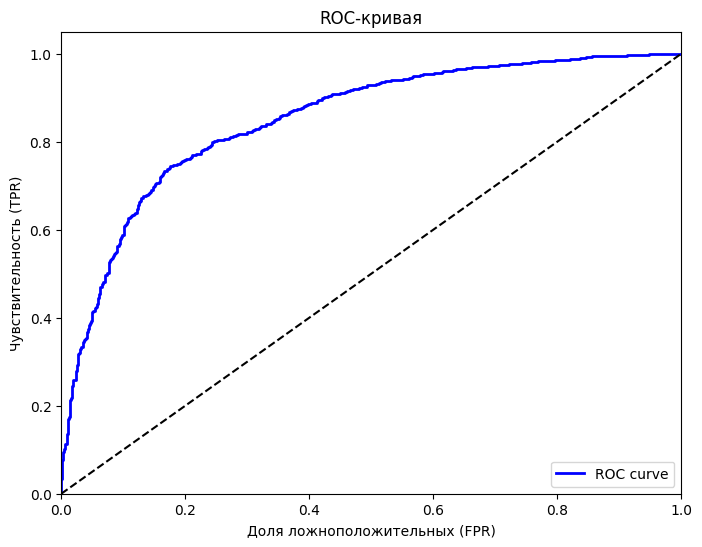

In [271]:
# добавим в проект соответсвующие зависимости необходимые для дальнейшей реализации
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# вычисление ROC-кривой с помощью roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
# где:
# fpr: False Positive Rate (доля ложноположительных классификаций)
# tpr: True Positive Rate (доля истинно положительных классификаций)
# thresholds: Пороговые значения, при которых вычисляются соответствующие значения fpr и tpr.

# построим график ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # пунктир (линия случайной классификации)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложноположительных (FPR)') # показывает, как часто модель неправильно классифицирует отрицательные объекты как положительные
plt.ylabel('Чувствительность (TPR)') # показывает, насколько хорошо модель классификации способна обнаруживать положительные объекты
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

_ROC-кривая в изгибе тянется к левому верхнему углу, что характеризует бинарную модель как эффективную_

## Вычисляем значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score

ROC-AUC как метрика определяет показывает на сколько эффективна та или иная модель классификации.
- если получается значение близкое к 0,5 это означает что модель не является эффективной, и предсказывает как случайное угадывание
- если же значение стремится к 1 то метрика показывает что модель является эффективной, и способна справится с задачами классификации

__Для вычисления ROC-AUC метрики используем функцию `roc_auc_score`:__

In [267]:
# Вычисление значения ROC-AUC метрики
roc_auc = roc_auc_score(y_test, y_probs)
print(f"Значение ROC-AUC: {roc_auc:.2f}") # оставим два знака после запятой

Значение ROC-AUC: 0.85


Значение `ROC-AUC` показывает что модель эффективна, имеет способность справится с задачей классификации.

## Реализуем подсчет метрик TPR, FPR вручную

Реализуем пользовательскую функцию `compute_tpr_fpr_manual`. Функция будет принимать три аргумента:

- y_true — массив истинных значений классов (0 или 1), то есть фактические метки классов для данных.
- y_pred_probs — массив предсказанных вероятностей для положительного класса (класса 1).
- threshold — пороговое значение. Если вероятность предсказания выше или равна этому порогу, объект классифицируется как класс 1, иначе — как класс 0.

Возвращать она будет `TPR` и `FPR`.

In [272]:
import numpy as np

def compute_tpr_fpr_manual(y_true, y_pred_probs, threshold):

    # Классификация по порогу
    y_pred_thresholded = (y_pred_probs >= threshold).astype(int)
    
    # Подсчет TP, FP, TN, FN
    TP = np.sum((y_true == 1) & (y_pred_thresholded == 1))
    FP = np.sum((y_true == 0) & (y_pred_thresholded == 1))
    TN = np.sum((y_true == 0) & (y_pred_thresholded == 0))
    FN = np.sum((y_true == 1) & (y_pred_thresholded == 0))
    
    # Вычисление TPR и FPR
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
    
    return TPR, FPR

Проведем пример вычисления TPR и FPR для порога 0.5

In [276]:
threshold = 0.5
tpr_manual, fpr_manual = compute_tpr_fpr_manual(y_test, y_probs, threshold)
print(f"TPR (вручную): {tpr_manual:.2f}, FPR (вручную): {fpr_manual:.2f}")

TPR (вручную): 0.80, FPR (вручную): 0.24


## Строим ROC-кривую с помощью вычисленных вручную метрик и объеденение графиков

Напишем код для выполнения ручного вычисление метрик TPR (True Positive Rate) и FPR (False Positive Rate) для различных порогов thresholds в задаче бинарной классификации.

__Вычисление TPR и FPR для разных порогов:__

In [277]:
# вычисление TPR и FPR вручную для различных порогов
thresholds_manual = np.linspace(0, 1, 100)  # создаем 100 порогов от 0 до 1, с помощью np.linspace

# создаем пустые списки для хранения значений
tpr_list = []
fpr_list = []

# используем цикл for для вычисления метрик на каждом полученном пороге
for threshold in thresholds_manual:
    tpr, fpr = compute_tpr_fpr_manual(y_test, y_probs, threshold)
    tpr_list.append(tpr)
    fpr_list.append(fpr)

__Визуализация ROC-кривой:__

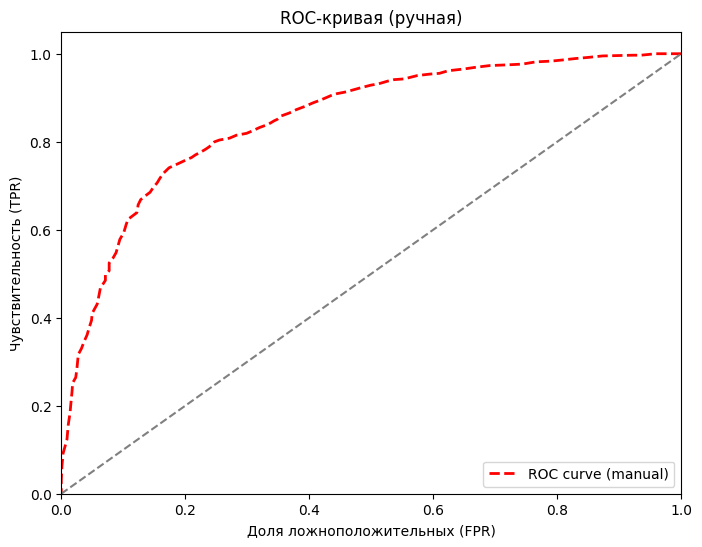

In [278]:
# Построение ROC-кривой с использованием sklearn и вручную
plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (sklearn)')
plt.plot(fpr_list, tpr_list, color='red', lw=2, linestyle='--', label='ROC curve (manual)')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайной классификации
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложноположительных (FPR)')
plt.ylabel('Чувствительность (TPR)')
plt.title('ROC-кривая (ручная)')
plt.legend(loc="lower right")
plt.show()

## Постройте график Precision-Recall, используя метрики, посчитанные выше

__Функция для вычисления Precision и Recall вручную:__

In [248]:
def compute_precision_recall_manual(y_true, y_pred_probs, threshold):
    
    # Классификация по порогу
    y_pred_thresholded = (y_pred_probs >= threshold).astype(int)
    
    # Подсчет TP, FP, FN
    TP = np.sum((y_true == 1) & (y_pred_thresholded == 1))
    FP = np.sum((y_true == 0) & (y_pred_thresholded == 1))
    FN = np.sum((y_true == 1) & (y_pred_thresholded == 0))
    
    # Вычисление Precision и Recall
    Precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    Recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    return Precision, Recall

__Вычисление Precision и Recall для разных порогов:__

In [249]:
# Вычисление Precision и Recall для различных порогов
precision_list = []
recall_list = []

for threshold in thresholds_manual:
    precision, recall = compute_precision_recall_manual(y_test, y_probs, threshold)
    precision_list.append(precision)
    recall_list.append(recall)

__Визуализация графика Precision-Recall:__

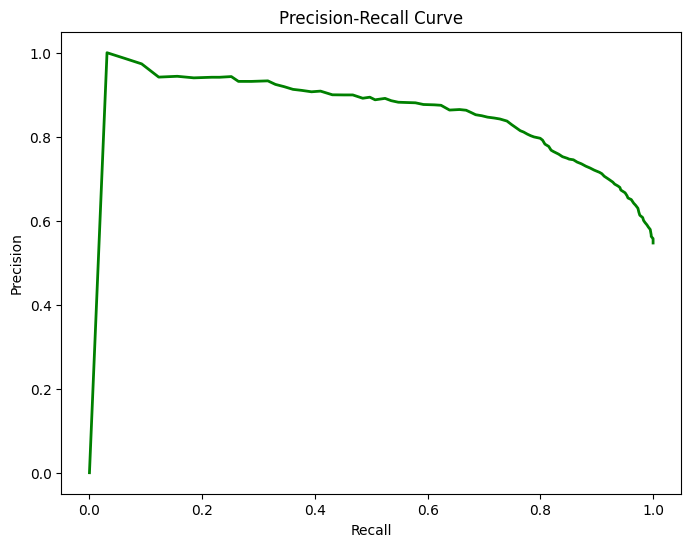

In [250]:
# Визуализация графика Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall_list, precision_list, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## Вычислите значение ROC-AUC метрики, используя метрики, посчитанные вручную

Чтобы вычислить значение ROC-AUC метрики вручную, можно воспользоваться методом численного интегрирования, например, методом трапеций.

__Вычисление ROC-AUC вручную с использованием TPR и FPR:__

In [251]:
from sklearn.metrics import auc

roc_auc_manual = auc(fpr_list, tpr_list)
print(f'Ручной ROC-AUC: {roc_auc_manual:.2f}')

Ручной ROC-AUC: 0.85


__Выводы:__

- Цель контрольной работы: "закрепить знания о математическом смысле метрик TPR, FPR. Изучить построение ROC-кривой, графика Precision-Recall" - выполнена, был опробован весь инструментарий, который позволяет реализовать построение ROC-кривой и соответствующих графиков, опробованы и реализованы средства языка по работе с данными, их обработке и дальнейшему использованию в качестве тестовой и обучающей выборок.
- ROC-кривые: Обе ROC-кривые (рассчитанная вручную и с помощью sklearn) имеют похожий график. Что подтверждает корректность вычислений вручную.
- ROC-AUC: Значение AUC, посчитанное вручную, аналогично тому, что рассчитано через sklearn.metrics.roc_auc_score, что также подтверждает правильность ручных вычислений.
- сама полученная модель эффективна в выполнении задч классификации, о чем свидетельствует `ROC-AUC`, который равен 0,85 